In [2]:
#import packages
import os
import pandas as pd
import numpy as np

In [13]:
df = pd.read_excel('bank.xlsx') #Read excel file
df['target'] = df['y'].apply(lambda x : 1 if x == 'yes' else 0)  # Convert to numeric
df = df.drop('y',axis=1)

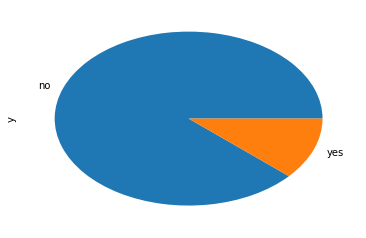

In [10]:
df['y'].value_counts().plot(kind='pie')

In [12]:
df['target'] = df['y'].apply(lambda x : 1 if x == 'yes' else 0)  # Convert to numeric
df = df.drop('y',axis=1)

In [18]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,0


## WOE AND IV

#### 1) first WAY

In [36]:
def woe(df, target,var,bins = 10,fill_na = True):
    df = df.copy()


    if(df[var].dtype.kind in 'biufc'):
        df['decile']=pd.qcut(df[i].rank(method='first'), bins, labels=False) ### Rank 
        if (fill_na== True):
            df['decile'] = df['decile'].fillna(value="Missing")
        Rank=df.groupby('decile').apply(lambda x: pd.Series([
            np.sum(x[target]),
            np.size(x[target][x[target]==0]),
            ],
            index=(["cnt_resp","cnt_non_resp"])
            )).reset_index()


    else:
        if (fill_na== True):
            df[var] = df[var].fillna(value="Missing")
        Rank=df.groupby(var).apply(lambda x: pd.Series([
            np.sum(x[target]),
            np.size(x[target][x[target]==0]),
            ],
            index=(["cnt_resp","cnt_non_resp"])
            )).reset_index()

    Rank["pct_resp"]=Rank["cnt_resp"]/np.sum(Rank["cnt_resp"])
    Rank["pct_non_resp"]=Rank["cnt_non_resp"]/np.sum(Rank["cnt_non_resp"])
    Rank["WOE"] = np.log(Rank["pct_resp"] / Rank["pct_non_resp"])


    return(Rank)
    



#### 2) second WAY

In [43]:
def get_IV(df, feature, target):
    lst = []

    # optional
    # df[feature] = df[feature].fillna("NULL")

    unique_values = df[feature].unique()
    for val in unique_values:
        lst.append([feature,                                                        # Feature name
                    val,                                                            # Value of a feature (unique)
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]   # Bad  (Fraud == 1)
                   ])
 
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'Good', 'Bad'])

        
    total_bad = df[df[target] == 1].count()[feature]
    total_good = df.shape[0] - total_bad
    
    data['Distribution Good'] = data['Good']/ total_good
    data['Distribution Bad'] = data['Bad'] / total_bad
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))
    data['WoE']= data['WoE']*-1
    iv = data['IV'].sum()

    return iv, data

## list Of Targets

In [54]:
df.drop(columns='target').columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'],
      dtype='object')

## evaluate the IV (strong or weak predictor)

- < 0.02         **useless predictor**
- 0.02 - 0.1     **Weak Predictor**
- 0.1 - 0.3      **Medium Predictor**
- 0.3 -0.5       **Strong Predictor**
- '>' 0.5          **Suspicious or too good to be true**

In [66]:
number= ['< 0.02','0.02 - 0.1','0.1 - 0.3','0.3 - 0.5','> 0.5']
information= list((['useless predictor', 'weak predictor', 'medium predictor',
              'strong predictor','Suspicious or Too good to be true']))
informationvalue= pd.DataFrame(number,columns=['Information Value'])
informationvalue['Predictive Power']= information
informationvalue
# len(info)
                                          

,Information Value,Predictive Power
0,< 0.02,useless predictor
1,0.02 - 0.1,weak predictor
2,0.1 - 0.3,medium predictor
3,0.3 - 0.5,strong predictor
4,> 0.5,Suspicious or Too good to be true


#### WOE of columns='Job'

In [55]:
woejob= woe(df=df,target='target',var='job',bins=10,fill_na=True)
job,jobIV= get_IV(df=df,feature='job',target='target')
woejob

,job,cnt_resp,cnt_non_resp,pct_resp,pct_non_resp,WOE
0,admin.,58,420,0.111324,0.10500,0.058488
1,blue-collar,69,877,0.132438,0.21925,-0.504101
2,entrepreneur,15,153,0.028791,0.03825,-0.284088
3,housemaid,14,98,0.026871,0.02450,0.092389
4,management,131,838,0.251440,0.20950,0.182479
5,retired,54,176,0.103647,0.04400,0.856800
6,self-employed,20,163,0.038388,0.04075,-0.059718
7,services,38,379,0.072937,0.09475,-0.261650
8,student,19,65,0.036468,0.01625,0.808351
9,technician,83,685,0.159309,0.17125,-0.072279


In [56]:
jobIV

,Variable,Value,Good,Bad,Distribution Good,Distribution Bad,WoE,IV
0,job,admin.,420,58,0.10500,0.111324,0.058488,0.000370
1,job,blue-collar,877,69,0.21925,0.132438,-0.504101,0.043762
2,job,entrepreneur,153,15,0.03825,0.028791,-0.284088,0.002687
3,job,housemaid,98,14,0.02450,0.026871,0.092389,0.000219
4,job,management,838,131,0.20950,0.251440,0.182479,0.007653
5,job,retired,176,54,0.04400,0.103647,0.856800,0.051105
6,job,self-employed,163,20,0.04075,0.038388,-0.059718,0.000141
7,job,services,379,38,0.09475,0.072937,-0.261650,0.005707
8,job,student,65,19,0.01625,0.036468,0.808351,0.016344
9,job,technician,685,83,0.17125,0.159309,-0.072279,0.000863
